In [78]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
stats_signif = 13
n_base_scenarios = 10
n_test_scenarios = 8
n_rule_scenarios = 32

In [9]:
import os
os.path.abspath(os.getcwd())

'/Users/nell/Documents/GitHub/social-contracts/examples/eval_scripts'

In [34]:
baseline_dfs = [[] for _ in range(n_base_scenarios)]
for scenario in range(n_base_scenarios):
        for k in range(stats_signif):
            path = f"../results/base/scenario{scenario+1}/"
            filename = f"trial{k+1}.csv"
            if filename in os.listdir(path):
                whole = path + filename
                baseline_df = pd.read_csv(whole)
                baseline_dfs[scenario].append(baseline_df)


In [36]:
test_dfs = [[] for _ in range(n_test_scenarios)]
for scenario in range(n_test_scenarios):
        for k in range(13):
            path = f"../results/test/scenario{scenario+1}/"
            filename = f"trial{k+1}..csv"
            if filename in os.listdir(path):
                whole = path + filename
                test_df = pd.read_csv(whole)
                test_dfs[scenario].append(test_df)

In [37]:
rules_dfs = [[] for _ in range(n_rule_scenarios)]
for scenario in range(n_rule_scenarios):
        for k in range(13):
            path = f"../results/rule_trials/rule_set{scenario+1}/"
            filename = f"trial{k+1}..csv"
            if filename in os.listdir(path):
                whole = path + filename
                rules_df = pd.read_csv(whole)
                rules_dfs[scenario].append(rules_df)

In [112]:
settings_path = "../results/settings.csv"
settings_names_path = "../results/settings_names.csv"
settings_lambda_path = "../results/settings_lambda.csv"
settings = pd.read_csv(settings_path)
settings_names = pd.read_csv(settings_names_path)
settings_lambda = pd.read_csv(settings_lambda_path)


/var/folders/4v/9klk9mnx3590cr7wzzyykff00000gn/T/ipykernel_63623/1251237490.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8,6))


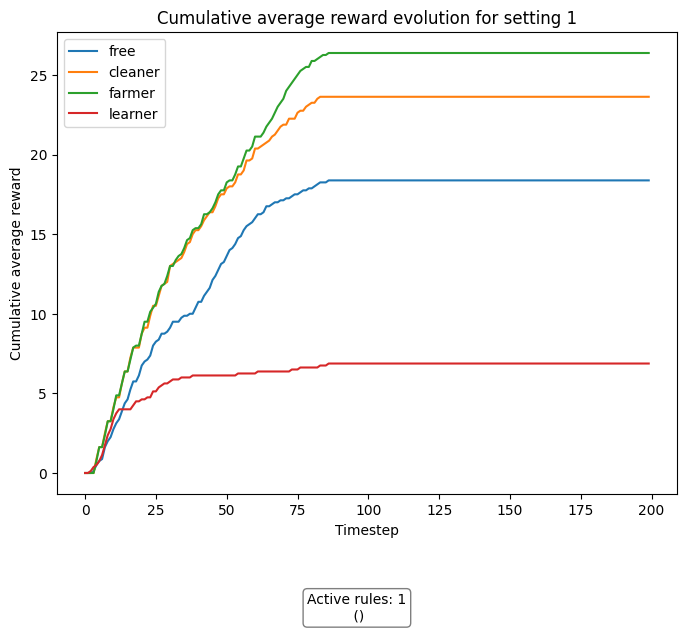

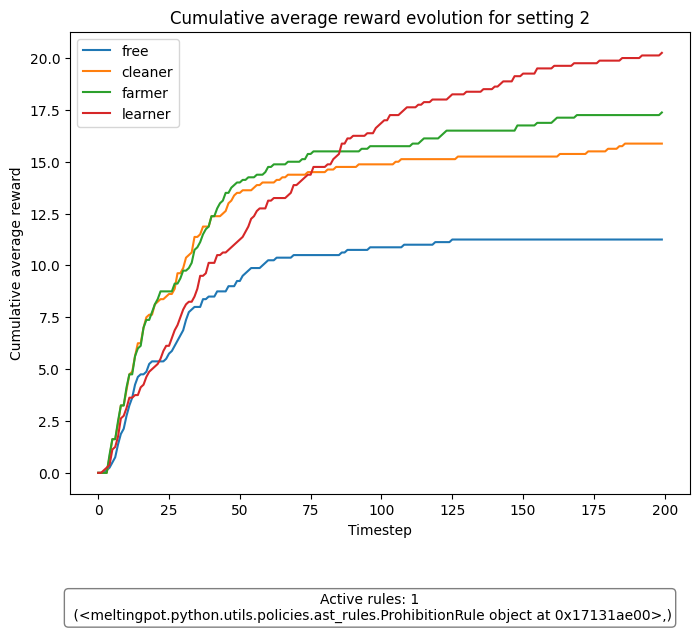

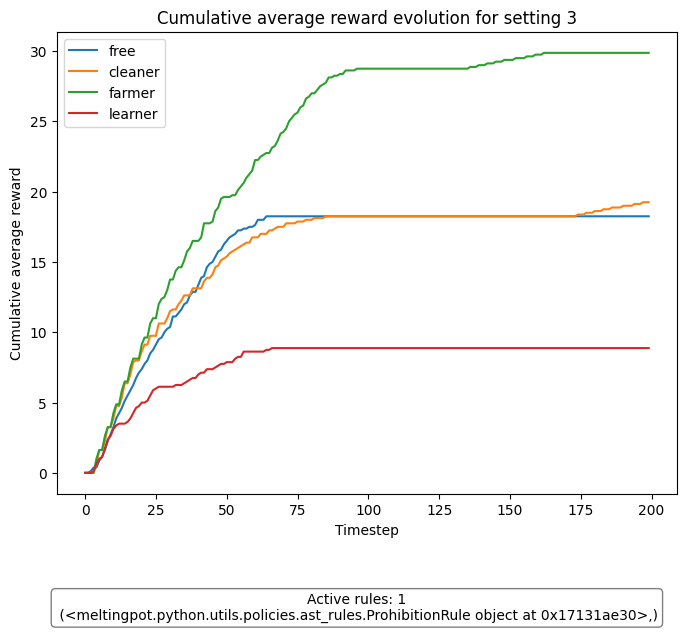

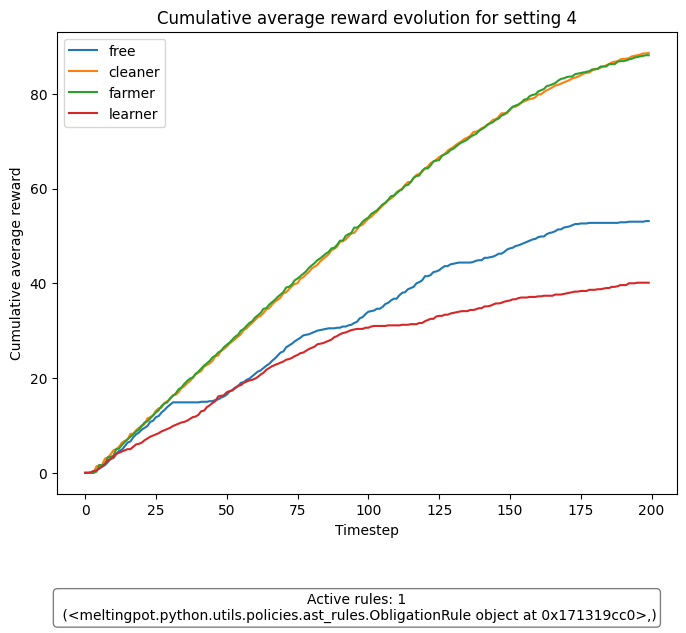

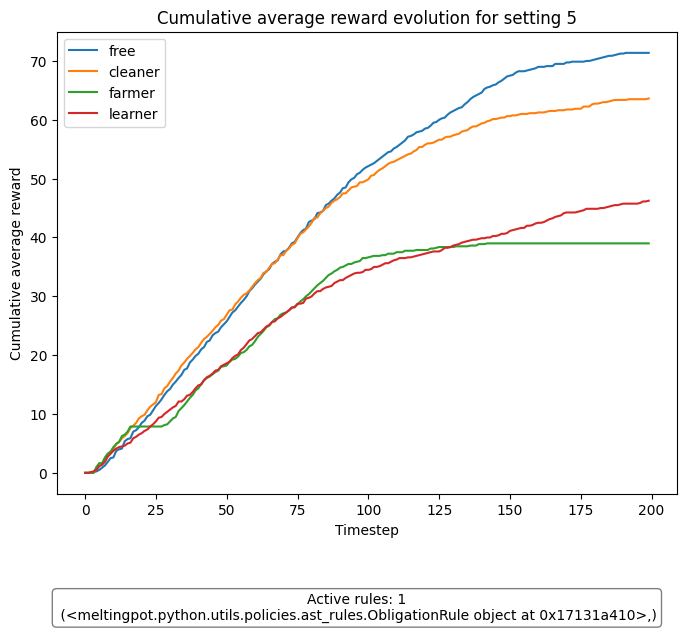

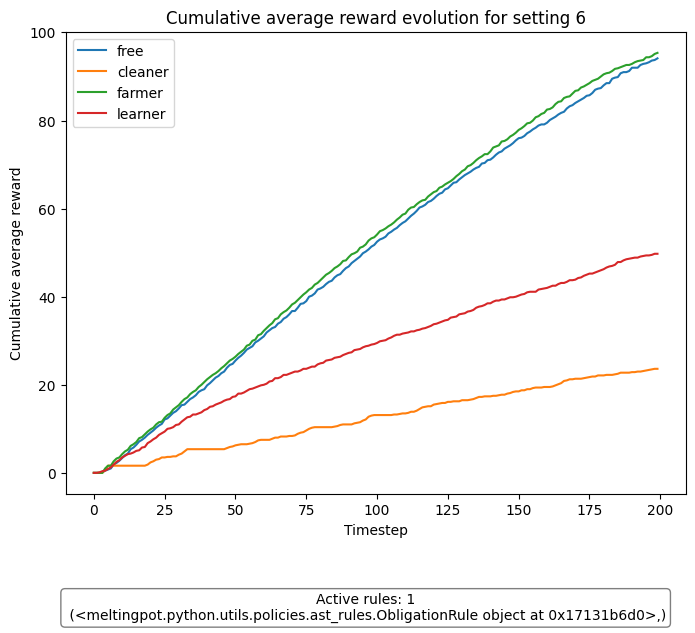

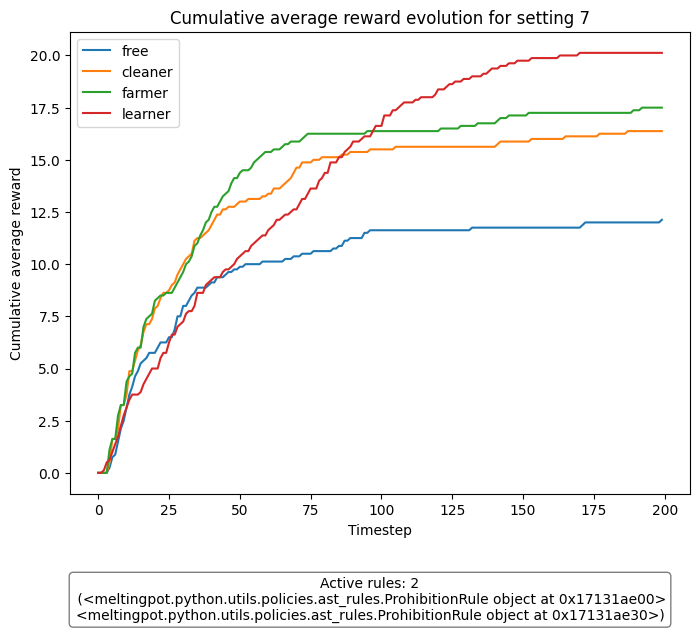

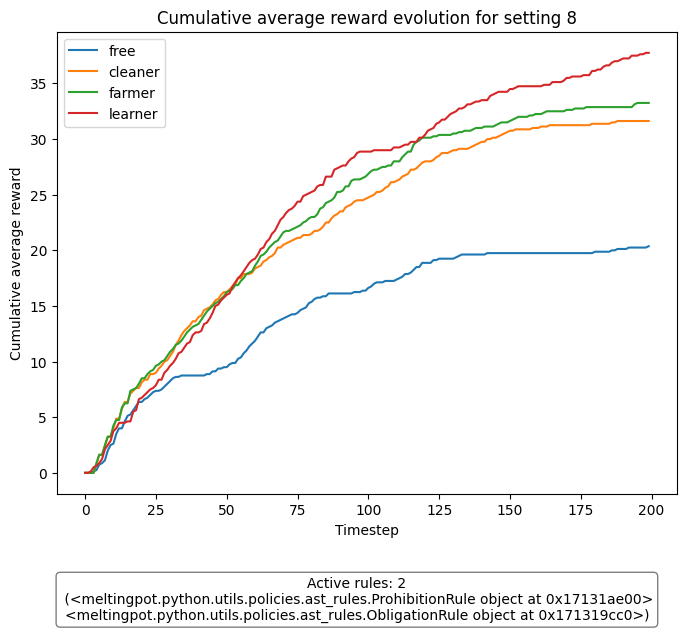

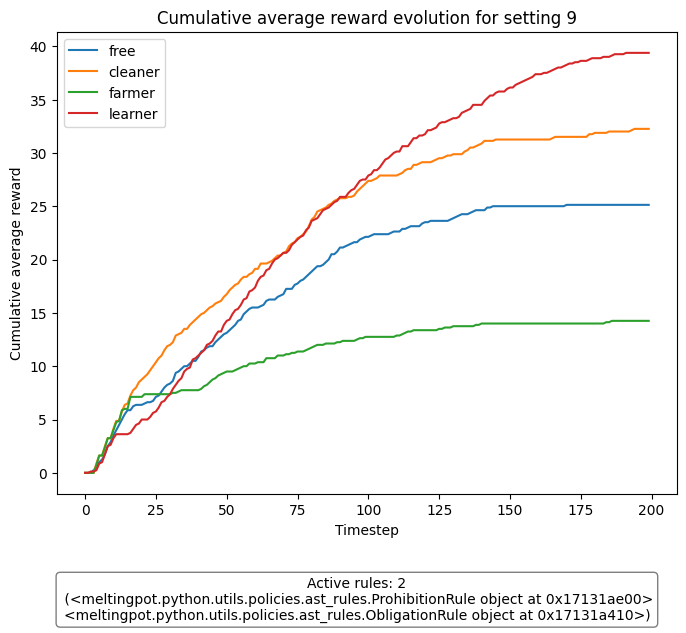

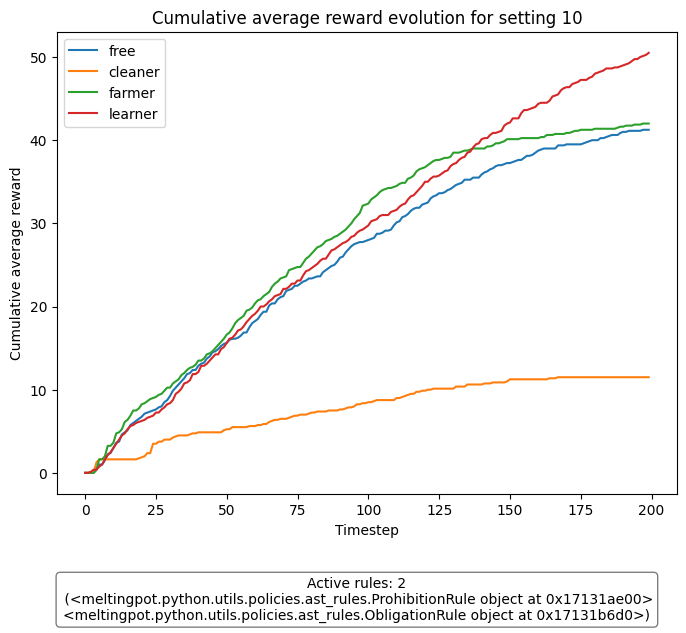

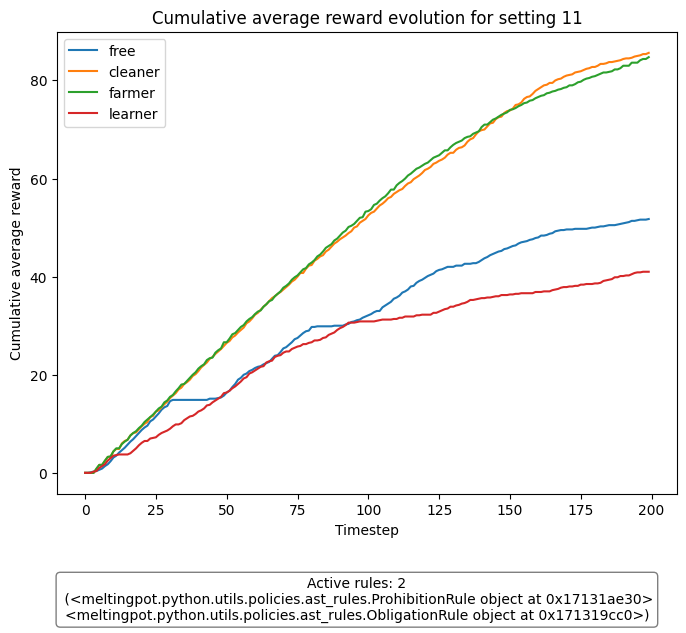

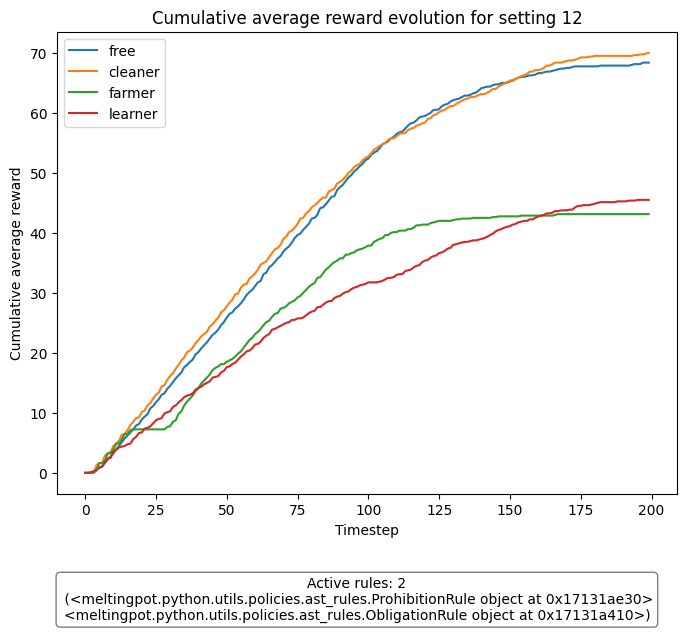

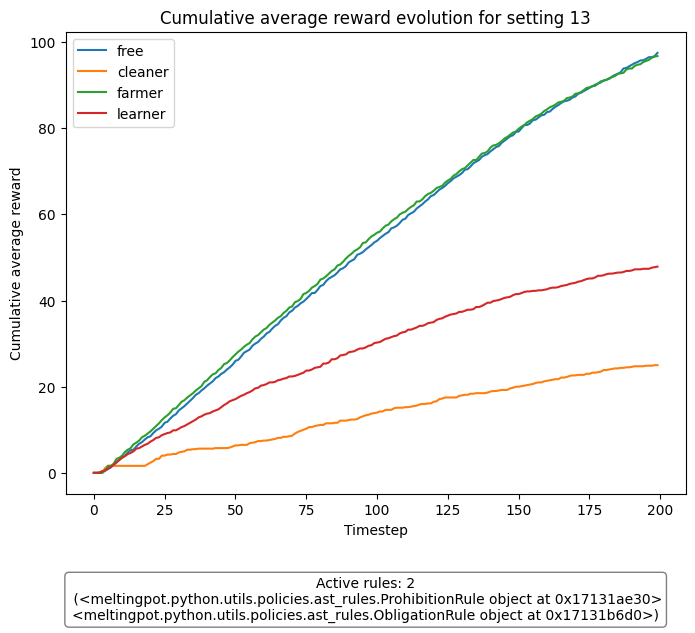

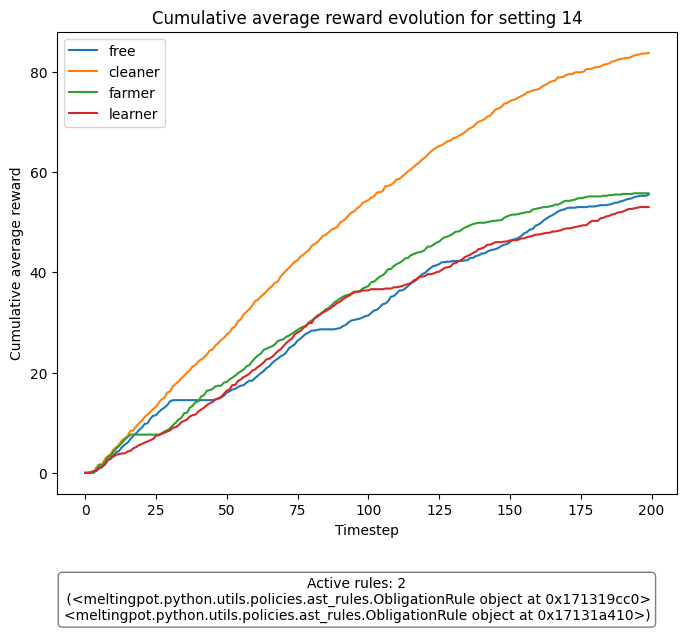

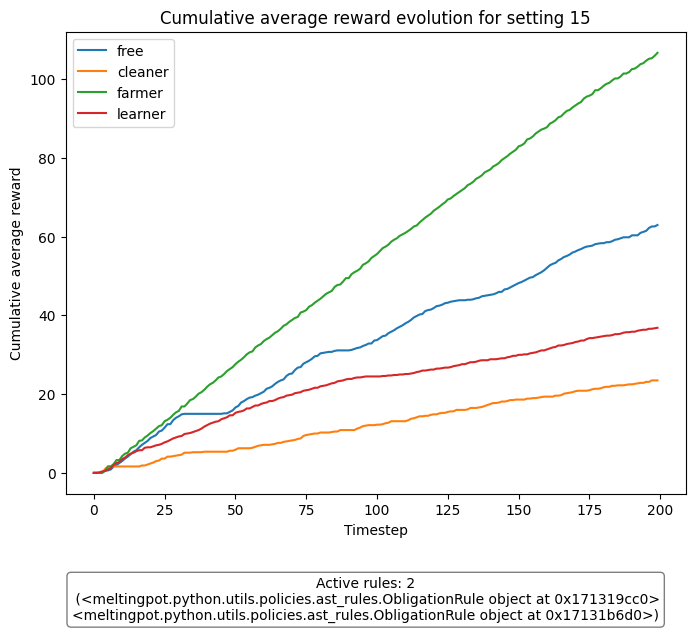

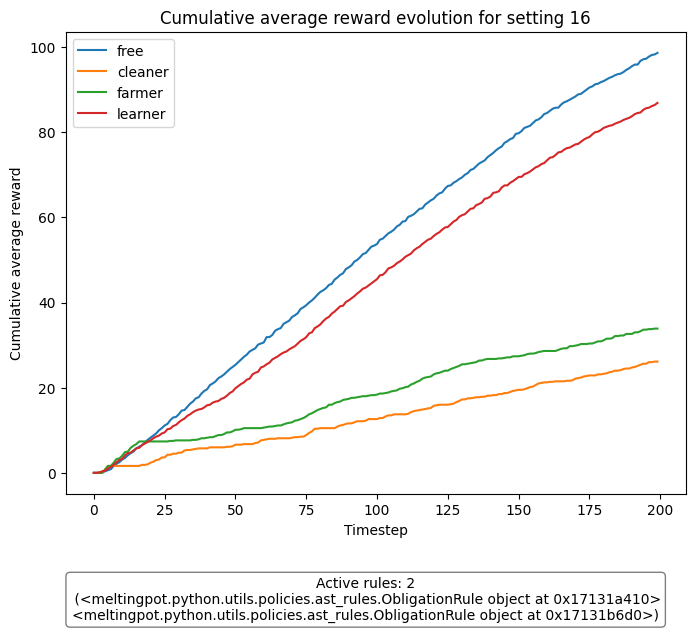

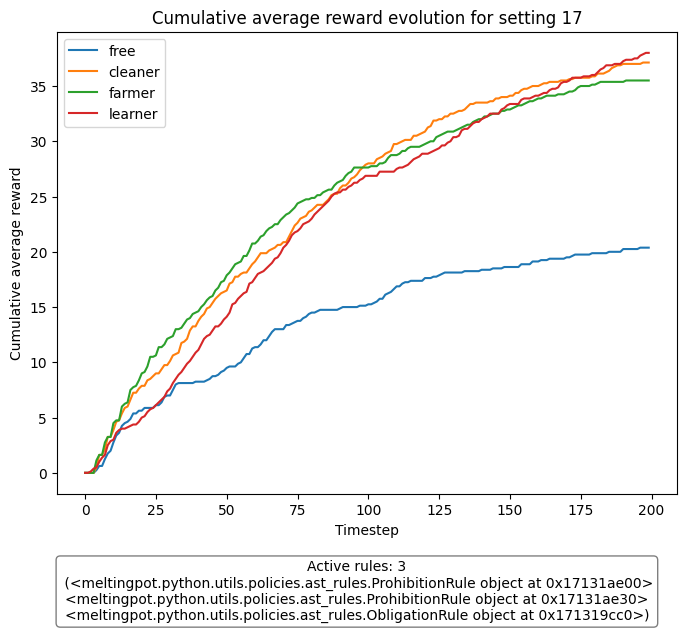

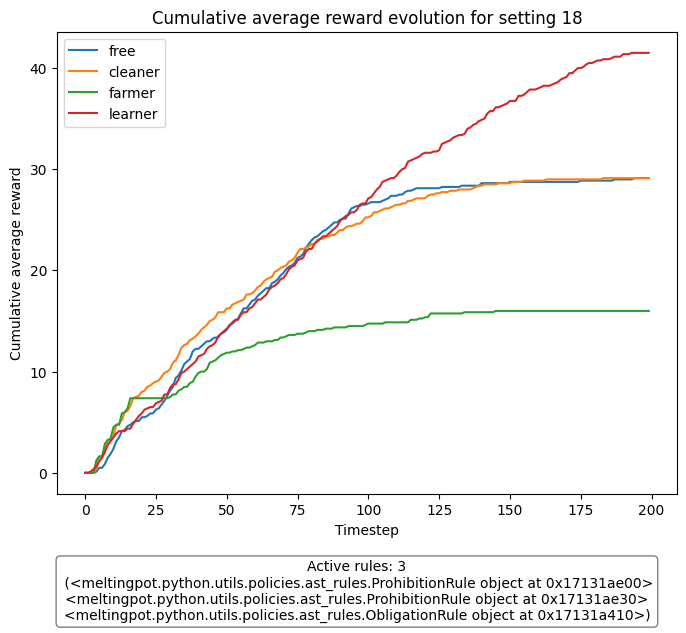

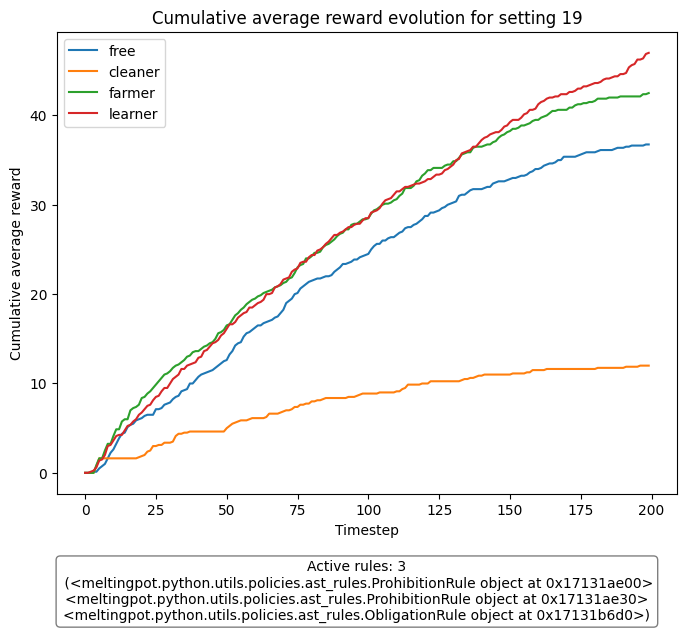

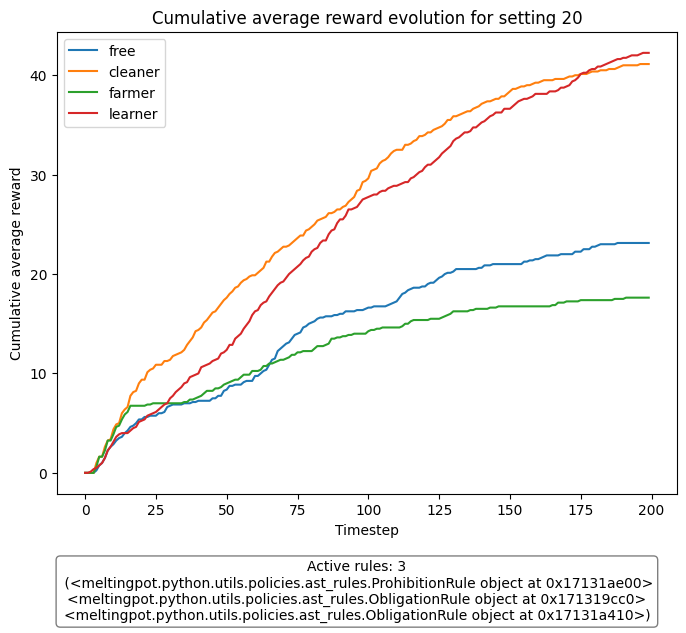

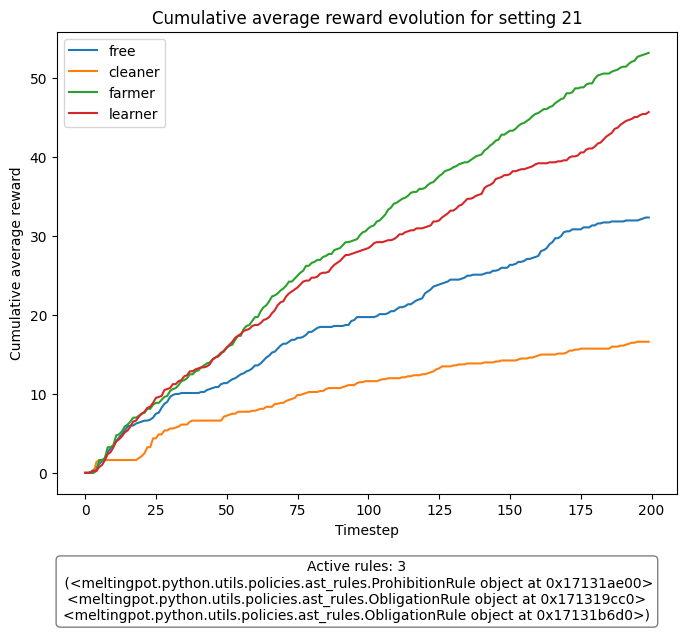

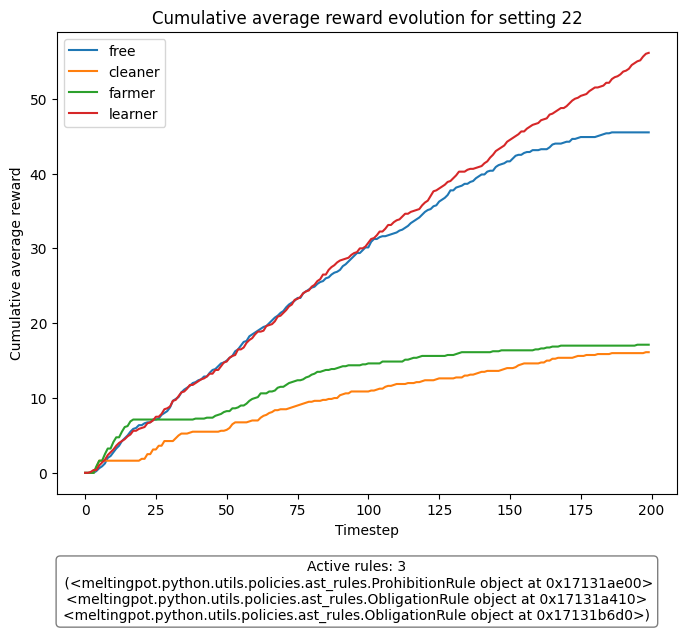

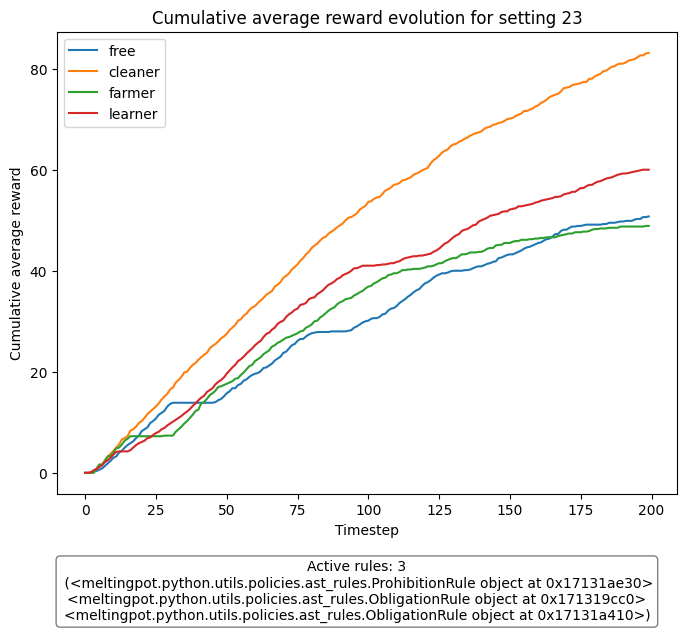

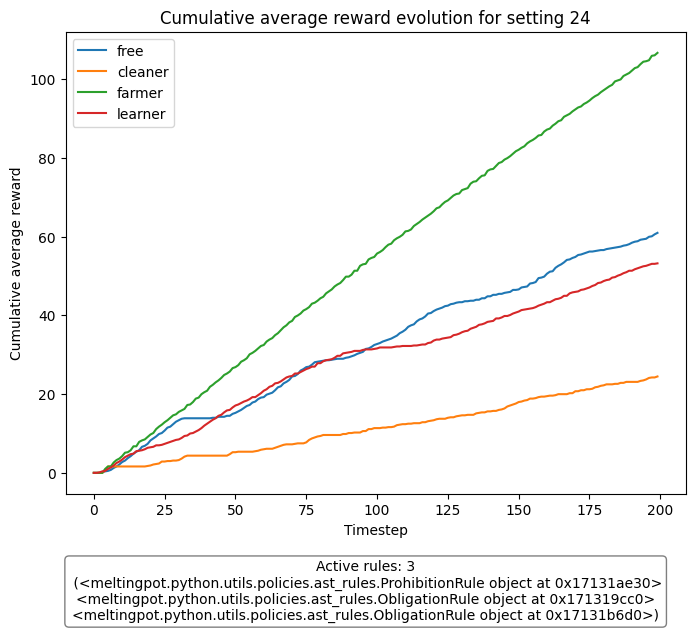

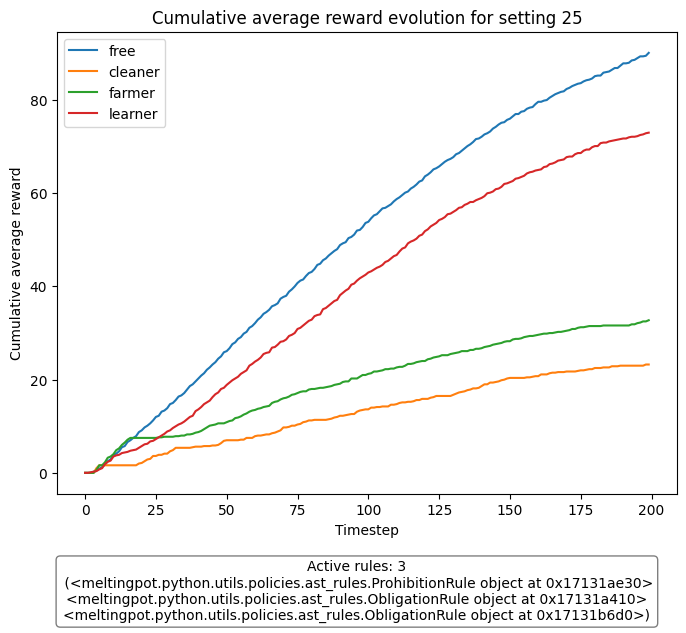

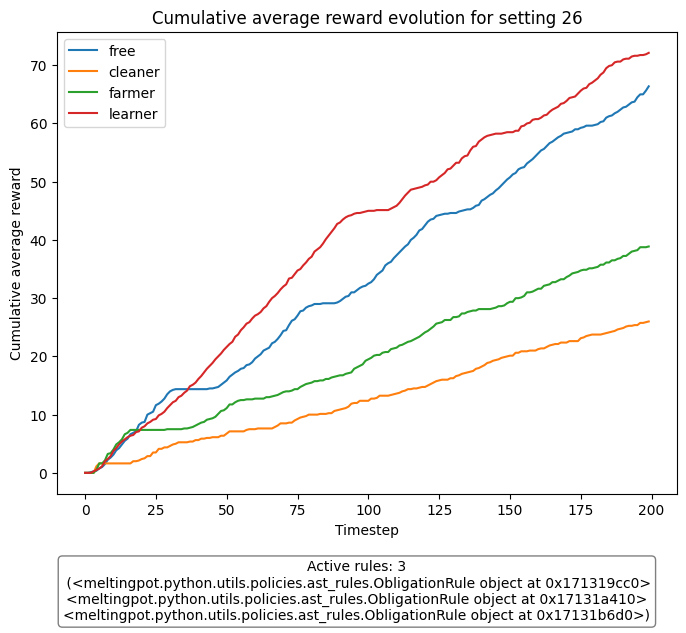

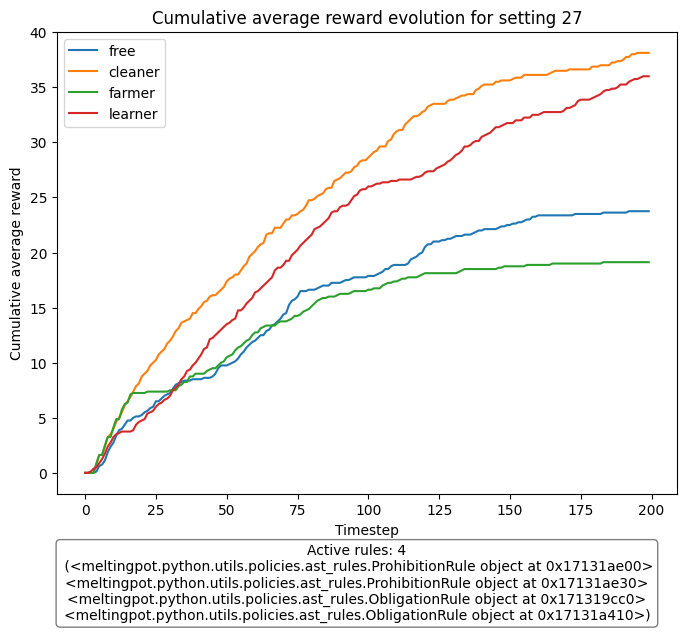

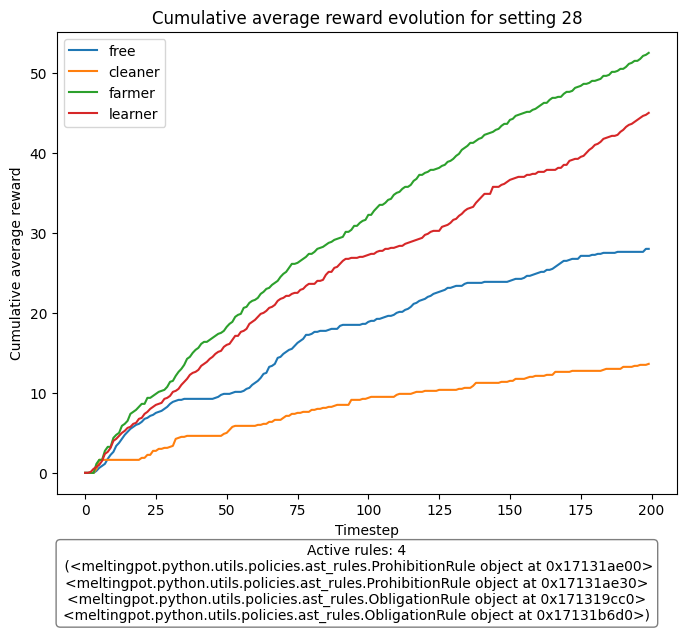

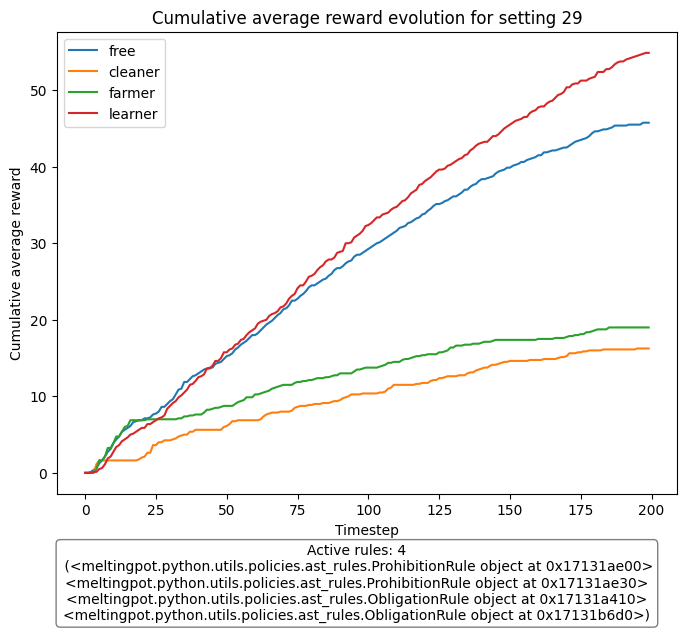

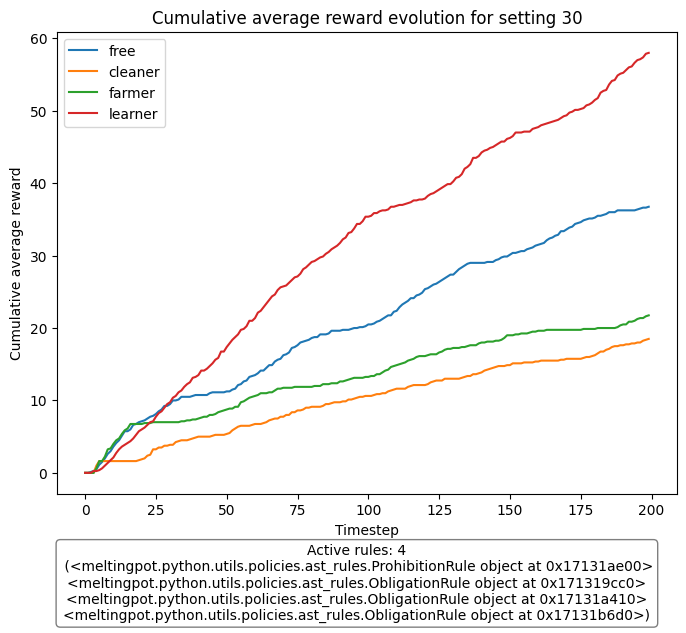

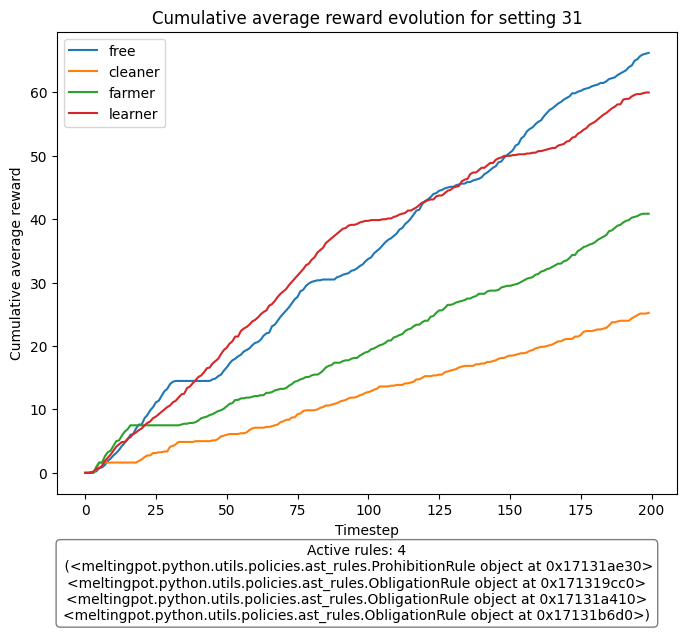

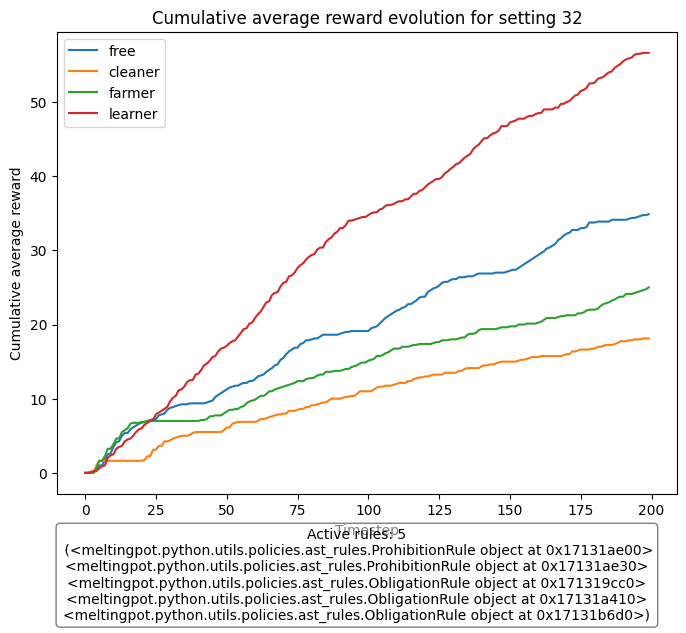

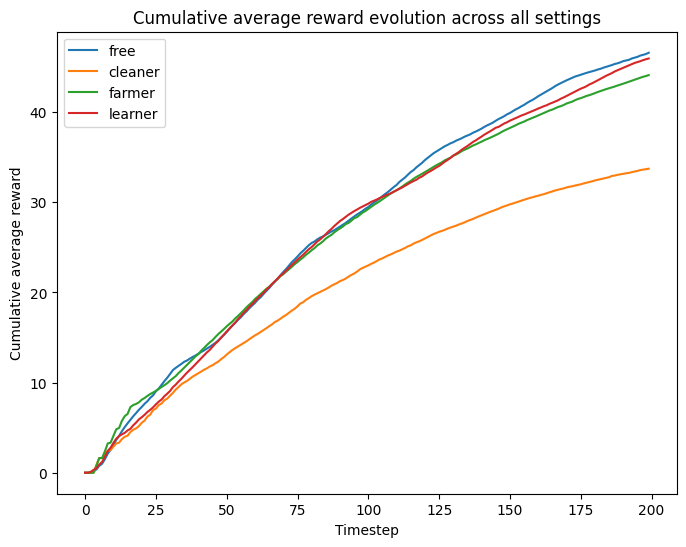

In [75]:
# data is stored in a list of 32 lists called `data_list`
averages = []
for i in range(32):
    fig, ax = plt.subplots(figsize=(8,6))
    mean_rewards = pd.DataFrame() # Initialize an empty DataFrame to store the mean rewards for the current setting
    for j in range(13):
        df = rules_dfs[i][j] # Get the j-th dataframe for the i-th setting
        rewards = df.iloc[:, 1:5] # Get the first 4 columns (rewards per timestep)
        mean_rewards = mean_rewards.add(rewards, fill_value=0) # Add the rewards to the running sum in mean_rewards
    mean_rewards = mean_rewards.divide(12) # Divide the sum by the number of dataframes (8) to get the mean
    mean_rewards_cum = mean_rewards.cumsum() # Compute the cumulative mean rewards
    cur_rules = settings_names.iloc[i, 3].split(", ")
    rule_out = '\n'.join([str(elem) for elem in cur_rules])
    info_text = f"Active rules: {len(cur_rules)}\n {rule_out}"
    ax.text(0.5, -0.1, info_text, ha="center", transform=fig.transFigure, fontsize=10,
         bbox=dict(facecolor='white', alpha=0.5, boxstyle="round"))
    averages.append(mean_rewards) # Add the mean rewards to the list of averages for all settings
    ax.plot(mean_rewards_cum) # Plot the cumulative mean reward evolution for the current setting
    ax.set_title(f"Cumulative average reward evolution for setting {i+1}")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Cumulative average reward")
    ax.legend(labels=mean_rewards.columns) # Add a legend with the column names
    plt.show()
    
# Plot the average rewards across all settings
fig, ax = plt.subplots(figsize=(8,6))
average_rewards = pd.concat(averages).groupby(level=0).mean() # Concatenate all mean rewards and compute the average across all settings
average_rewards_cum = average_rewards.cumsum() # Compute the cumulative average rewards
ax.plot(average_rewards_cum) # Plot the cumulative average reward evolution for all settings
ax.set_title("Cumulative average reward evolution across all settings")
ax.set_xlabel("Timestep")
ax.set_ylabel("Cumulative average reward")
ax.legend(labels=average_rewards.columns) # Add a legend with the column names
plt.savefig('cum_rewards')
plt.show()

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the list of rules
rules = [rule for rule in settings_lambda.iloc[31, 3].strip("(").strip(")").split(", ")]

# Define the thresholds for probability
thresholds = [0.5, 0.75, 0.99]

# Loop over the settings and trials
rule_probs = []
true_rule_probs = pd.DataFrame()
for i in range(32):
    cur_rules = []
    cur_rules = settings_lambda.iloc[i, 3].strip("(").strip(")").split(", ")
    if "" in cur_rules:
        cur_rules.remove("")
    for rule in cur_rules:
        for j in range(13):
            # Get the dataframe for the current trial
            df = rules_dfs[i][j] # Get the j-th dataframe for the i-th setting
            probs = df[rule].values
            print(probs)
            rule_probs.append(probs)
        # Compute the mean probabilities for the current rule and setting
        mean_probs = np.mean(rule_probs, axis=0)
        # Add the mean probabilities to the DataFrame
        true_rule_probs = true_rule_probs.append(pd.Series(mean_probs, index=true_rule_probs.columns), ignore_index=True)

# Divide the sum by the number of settings (32*13) to get the mean
true_rule_probs = true_rule_probs.mean() / (32*13)

prob_at_5 = []
prob_at_10 = []
prob_at_20 = []
probs_over_05 = []
probs_over_075 = []
probs_over_095 = []

for rule in rules:
    prob_at_5.append(true_rule_probs[rule].iloc[5])
    prob_at_10.append(true_rule_probs[rule].iloc[10])
    prob_at_20.append(true_rule_probs[rule].iloc[20])

    probs_over_05.append((true_rule_probs[rule] > 0.5).idxmax())
    probs_over_075.append((true_rule_probs[rule] > 0.75).idxmax())
    probs_over_095.append((true_rule_probs[rule] > 0.95).idxmax())


print(prob_at_5)

[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2]
[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 

ValueError: Length of values (200) does not match length of index (0)

In [ ]:
    probs05 = np.argmax(np.array(mean_probs) > 0.5)
    probs075 = np.argmax(np.array(mean_probs) > 0.75)
    probs095 = np.argmax(np.array(mean_probs) > 0.95)
        
    # Get the probabilities at the specified time steps
    prob_at_5 = [mean_probs[rule].iloc[5] for rule in rules]
    prob_at_10 = [mean_probs[rule].iloc[10] for rule in rules]
    prob_at_20 = [mean_probs[rule].iloc[20] for rule in rules]
        
    # Store the values for this trial
    prob_over_05.append(probs05)
    prob_over_075.append(probs075)
    prob_over_095.append(probs095)
    prob_at_5.append(prob_at_5)
    prob_at_10.append(prob_at_10)
    prob_at_20.append(prob_at_20)

# Calculate the means and standard deviations for each rule
mean_prob_over_05 = np.mean(prob_over_05, axis=0)
std_prob_over_05 = np.std(prob_over_05, axis=0)

mean_prob_over_075 = np.mean(prob_over_075, axis=0)
std_prob_over_075 = np.std(prob_over_075, axis=0)

mean_prob_over_095 = np.mean(prob_over_095, axis=0)
std_prob_over_095 = np.std(prob_over_095, axis=0)

mean_prob_at_5 = np.mean(prob_at_5, axis=0)
std_prob_at_5 = np.std(prob_at_5, axis=0)

mean_prob_at_10 = np.mean(prob_at_10, axis=0)
std_prob_at_10 = np.std(prob_at_10, axis=0)

mean_prob_at_20 = np.mean(prob_at_20, axis=0)
std_prob_at_20 = np.std(prob_at_20, axis=0)

# Plot the box plots
fig, axs = plt.subplots(2, 3, figsize=(15,10))

axs[0, 0].boxplot(prob_over_05, labels=rules)
axs[0, 0].set_title("Probability over 0.5")
axs[0, 1].boxplot(prob_over_075, labels=rules)
axs[0, 1].set_title("Probability over 0.75")
axs[0, 2].boxplot(prob_over_095, labels=rules)